In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, concatenate
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Concatenate

# 데이터로드

In [ ]:
df1 = pd.read_csv('21-01-01~22-12-31강진면.csv')

In [ ]:
df2 = pd.read_csv('21-01-01~22-12-31신덕.csv')

In [ ]:
df3 = pd.read_csv('21-01-01~22-12-31곡성.csv')

In [ ]:
w_df = pd.read_csv('가탄교수위_re.csv')

In [ ]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(w_df.shape)

(17520, 10)
(17520, 10)
(17520, 10)
(17497, 2)


# 데이터 전처리

In [ ]:
features = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

In [ ]:
test_df1 = df1[features].values
test_df2 = df2[features].values
test_df3 = df3[features].values

In [ ]:
test_wdf = w_df[["수위"]].values

In [ ]:
print(test_df1.shape)
print(test_df2.shape)
print(test_df3.shape)
print(test_wdf.shape)

(17520, 5)
(17520, 5)
(17520, 5)
(17497, 1)


## 정규화

In [ ]:
# 정규화
scaler = MinMaxScaler()

# 상류 하천 데이터 정규화
test_df1_z = scaler.fit_transform(test_df1)
test_df2_z = scaler.fit_transform(test_df2)
test_df3_z = scaler.fit_transform(test_df3)
test_wdf_z = scaler.fit_transform(test_wdf)

In [ ]:
scaler = MinMaxScaler()
test_wdf_z = scaler.fit_transform(test_wdf)

In [ ]:
test_wdf_z = scaler.fit_transform(test_wdf)

In [ ]:
test_df1_z

array([[0.26987061, 0.69288703, 0.16666667, 0.        , 0.76744186],
       [0.23844732, 0.76596932, 0.10784314, 0.        , 0.87209302],
       [0.24214418, 0.83542538, 0.1372549 , 0.        , 0.86046512],
       ...,
       [0.30314233, 0.        , 0.00980392, 0.        , 0.94186047],
       [0.29759704, 0.        , 0.00980392, 0.        , 0.94186047],
       [0.2754159 , 0.19414226, 0.06862745, 0.        , 0.97674419]])

In [ ]:
test_wdf_z

array([[0.05668016],
       [0.05668016],
       [0.05668016],
       ...,
       [0.05668016],
       [0.05668016],
       [0.05668016]])

In [ ]:
print(test_df1_z.shape)
print(test_df2_z.shape)
print(test_df3_z.shape)
print(test_wdf_z.shape)

(17520, 5)
(17520, 5)
(17520, 5)
(17497, 1)


## 차원변환

- 강진면

In [ ]:
time_steps = 24
features = 10

new_data = []

for i in range(len(test_df1_z) - time_steps + 1):
    batch = test_df1_z[i:i+time_steps]
    new_data.append(batch)

test_df1_re = np.array(new_data)

In [ ]:
test_df1_re

array([[[0.26987061, 0.69288703, 0.16666667, 0.        , 0.76744186],
        [0.23844732, 0.76596932, 0.10784314, 0.        , 0.87209302],
        [0.24214418, 0.83542538, 0.1372549 , 0.        , 0.86046512],
        ...,
        [0.30683919, 0.        , 0.02941176, 0.        , 0.91860465],
        [0.31977819, 0.78995816, 0.06862745, 0.        , 0.90697674],
        [0.31977819, 0.25076709, 0.08823529, 0.        , 0.91860465]],

       [[0.23844732, 0.76596932, 0.10784314, 0.        , 0.87209302],
        [0.24214418, 0.83542538, 0.1372549 , 0.        , 0.86046512],
        [0.23475046, 0.        , 0.        , 0.        , 0.91860465],
        ...,
        [0.31977819, 0.78995816, 0.06862745, 0.        , 0.90697674],
        [0.31977819, 0.25076709, 0.08823529, 0.        , 0.91860465],
        [0.32162662, 0.26443515, 0.05882353, 0.        , 0.91860465]],

       [[0.24214418, 0.83542538, 0.1372549 , 0.        , 0.86046512],
        [0.23475046, 0.        , 0.        , 0.        , 0.9

In [ ]:
test_df1_re.shape

(17497, 24, 5)

- 신덕

In [ ]:
new_data = []

for i in range(len(test_df2_z) - time_steps + 1):
    batch = test_df2_z[i:i+time_steps]
    new_data.append(batch)

test_df2_re = np.array(new_data)

In [ ]:
test_df2_re.shape

(17497, 24, 5)

- 곡성

In [ ]:
new_data = []

for i in range(len(test_df3_z) - time_steps + 1):
    batch = test_df3_z[i:i+time_steps]
    new_data.append(batch)

test_df3_re = np.array(new_data)

In [ ]:
test_df3_re.shape

(17497, 24, 5)

In [ ]:
print("NumPy array dtype:", test_df2_re.dtype)

NumPy array dtype: float64


# 모델

- CNN_Lstm

In [ ]:
num_top = 3  # 상류 하천의 수
time_steps = 24
# 모델의 입력 레이어 정의
input_layers = []
input_shape = (time_steps, 5)
for i in range(num_top):
    input_layer = Input(shape=input_shape, name=f'aws_{i+1}')
    input_layers.append(input_layer)

# CNN 레이어 정의
cnn_layers = []
for i in range(num_top):
    cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layers[i])
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    cnn_layers.append(cnn_layer)

concatenated_outputs = Concatenate()(cnn_layers)
lstm_input = tf.keras.layers.Reshape((num_top, -1))(concatenated_outputs)  # LSTM에 입력하기 위해 차원 재구성


lstm_layer = LSTM(32, activation='relu')(lstm_input)

output_layer = Dense(1, activation='linear', name='water')(lstm_layer)

In [ ]:
# 모델 컴파일
model = Model(inputs=input_layers, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 aws_1 (InputLayer)          [(None, 24, 5)]              0         []                            
                                                                                                  
 aws_2 (InputLayer)          [(None, 24, 5)]              0         []                            
                                                                                                  
 aws_3 (InputLayer)          [(None, 24, 5)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 22, 64)               1024      ['aws_1[0][0]']               
                                                                                              

# 학습

In [ ]:
model.fit([test_df1_re, test_df2_re, test_df3_re], test_wdf_z, epochs=100, batch_size=32)

Epoch 1/100
547/547 [==============================] - 8s 10ms/step - loss: 0.0032 - mae: 0.0371
Epoch 2/100
547/547 [==============================] - 7s 12ms/step - loss: 0.0021 - mae: 0.0319
Epoch 3/100
547/547 [==============================] - 5s 9ms/step - loss: 0.0019 - mae: 0.0308
Epoch 4/100
547/547 [==============================] - 9s 17ms/step - loss: 0.0018 - mae: 0.0301
Epoch 5/100
547/547 [==============================] - 11s 20ms/step - loss: 0.0016 - mae: 0.0293
Epoch 6/100
547/547 [==============================] - 10s 19ms/step - loss: 0.0015 - mae: 0.0286
Epoch 7/100
547/547 [==============================] - 7s 14ms/step - loss: 0.0014 - mae: 0.0279
Epoch 8/100
547/547 [==============================] - 5s 9ms/step - loss: 0.0013 - mae: 0.0268
Epoch 9/100
547/547 [==============================] - 6s 12ms/step - loss: 0.0012 - mae: 0.0260
Epoch 10/100
547/547 [==============================] - 5s 9ms/step - loss: 0.0012 - mae: 0.0252
Epoch 11/100
547/547 [========

# 결과

In [ ]:
predictions = model.predict([test_df1_re, test_df2_re, test_df3_re])

547/547 [==============================] - 2s 4ms/step


In [ ]:
predictions_scale = scaler.inverse_transform(predictions)

In [ ]:
predictions_scale.shape

(17497, 1)

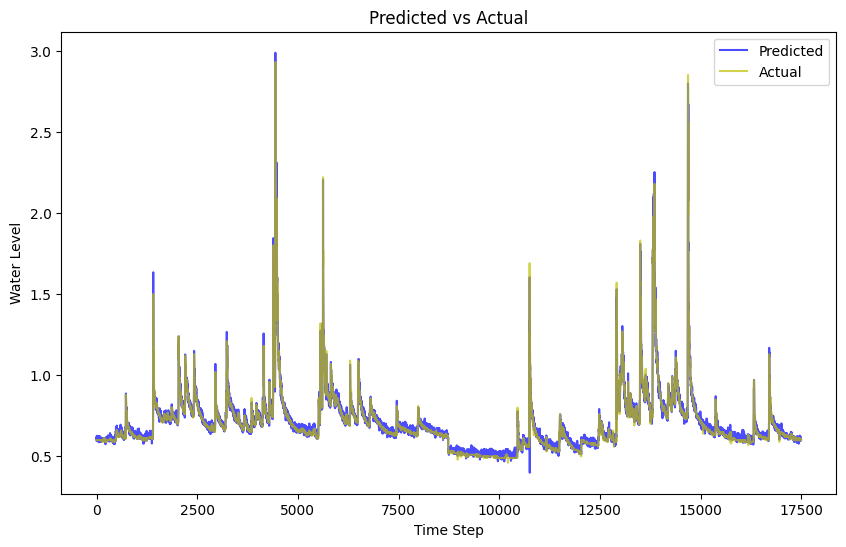

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(predictions_scale, label='Predicted', color = 'b', alpha=0.7)
plt.plot(test_wdf, label='Actual', color = 'y', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Water Level')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

In [ ]:
predictions_scale[:10]

array([[0.59865725],
       [0.61195886],
       [0.60619396],
       [0.61536974],
       [0.6062304 ],
       [0.6223958 ],
       [0.61794096],
       [0.62678486],
       [0.61632454],
       [0.6178945 ]], dtype=float32)

In [ ]:
model.save("model_test(24).h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from pickle import dump

dump(scaler, open('./24_cnn_scaler.pkl', 'wb'))

# 모델 테스트

- 걍다시 ㄱ

In [ ]:
t1 = pd.read_csv('11111.csv')

In [ ]:
t2 = pd.read_csv('22222.csv')

In [ ]:
t3 = pd.read_csv('33333.csv')

In [ ]:
tw = pd.read_csv('가탄교.csv')

In [ ]:
from keras.models import load_model

model_filename = 'model_test(24).h5'

loaded_model = load_model(model_filename)

In [ ]:
from pickle import load

load_minmax_scaler = load(open('24_cnn_scaler.pkl', 'rb'))

## 데이터 전처리

In [ ]:
features = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

In [ ]:
test_t1 = t1[features].values
test_t2 = t2[features].values
test_t3 = t3[features].values

### 정규화

In [ ]:
# 정규화
scaler = MinMaxScaler()

# 상류 하천 데이터 정규화
test_df1_z = scaler.fit_transform(test_t1)
test_df2_z = scaler.fit_transform(test_t2)
test_df3_z = scaler.fit_transform(test_t3)

In [ ]:
time_steps = 24
features = 10

new_data = []

for i in range(len(test_df1_z) - time_steps + 1):
    batch = test_df1_z[i:i+time_steps]
    new_data.append(batch)

test_df1_re = np.array(new_data)

In [ ]:
test_df1_re.shape

(49, 24, 5)

In [ ]:
time_steps = 24
features = 10

new_data = []

for i in range(len(test_df2_z) - time_steps + 1):
    batch = test_df2_z[i:i+time_steps]
    new_data.append(batch)

test_df2_re = np.array(new_data)

In [ ]:
time_steps = 24
features = 10

new_data = []

for i in range(len(test_df3_z) - time_steps + 1):
    batch = test_df3_z[i:i+time_steps]
    new_data.append(batch)

test_df3_re = np.array(new_data)

### 결과

In [ ]:
predictions = loaded_model.predict([test_df1_re, test_df2_re, test_df3_re])

2/2 [==============================] - 0s 7ms/step


In [ ]:
predictions

In [ ]:
predictions_scaler = scaler.inverse_transform(predictions)

In [ ]:
predictions_scaler

array([[0.46024662],
       [0.3857109 ],
       [0.45224482],
       [0.48980257],
       [0.59065366],
       [0.57029104],
       [0.6297887 ],
       [0.60353   ],
       [0.5483073 ],
       [0.63106495],
       [0.5920398 ],
       [0.54781526],
       [0.46616435],
       [0.39972517],
       [0.3645547 ],
       [0.45184898],
       [0.49223733],
       [0.5252815 ],
       [0.54574364],
       [0.6258877 ],
       [0.6030554 ],
       [0.6124969 ],
       [0.66126525],
       [0.6051811 ],
       [0.6450209 ],
       [0.5883132 ],
       [0.56307405],
       [0.48957336],
       [0.5028483 ],
       [0.5267521 ],
       [0.5508292 ],
       [0.4373453 ],
       [0.455012  ],
       [0.71564275],
       [0.69799954],
       [0.7287173 ],
       [0.7451732 ],
       [0.6185936 ],
       [0.60804737],
       [0.5887128 ],
       [0.60254467],
       [0.56577295],
       [0.49757725],
       [0.07606629],
       [0.2369207 ],
       [0.4217368 ],
       [0.5369204 ],
       [0.575

In [ ]:
predictions_scaler.shape

(49, 1)

## 3시간 테스트
-> 27개의데이터

In [ ]:
t1 = pd.read_csv('test1.csv')

In [ ]:
t2 = pd.read_csv('test2.csv')

In [ ]:
t3 = pd.read_csv('test3.csv')

In [ ]:
features = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

In [ ]:
t1

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),현지기압(hPa),해면기압(hPa),습도(%)
0,762,강진면,2023-08-16 00:00,24.0,293.9,1.8,0,985.3,1003.8,94
1,762,강진면,2023-08-16 01:00,23.6,293.7,1.0,0,985.0,1003.6,96
2,762,강진면,2023-08-16 02:00,23.8,275.2,1.0,0,984.8,1003.3,95
3,762,강진면,2023-08-16 03:00,23.2,318.4,0.8,0,984.8,1003.4,97
4,762,강진면,2023-08-16 04:00,22.5,0.0,0.0,0,984.6,1003.3,98
5,762,강진면,2023-08-16 05:00,22.0,0.0,0.1,0,984.7,1003.4,99
6,762,강진면,2023-08-16 06:00,22.5,0.0,0.2,0,985.0,1003.7,99
7,762,강진면,2023-08-16 07:00,23.6,246.8,1.1,0,985.4,1004.0,97
8,762,강진면,2023-08-16 08:00,25.1,236.8,0.7,0,985.5,1004.1,87
9,762,강진면,2023-08-16 09:00,26.5,208.0,0.8,0,985.7,1004.2,80


In [ ]:
test_t1 = t1[features].values
test_t2 = t2[features].values
test_t3 = t3[features].values

In [ ]:
# 정규화
scaler = MinMaxScaler()

# 상류 하천 데이터 정규화
test_df1_z = scaler.fit_transform(test_t1)
test_df2_z = scaler.fit_transform(test_t2)
test_df3_z = scaler.fit_transform(test_t3)

In [ ]:
time_steps = 24
features = 10

new_data = []

for i in range(len(test_df1_z) - time_steps + 1):
    batch = test_df1_z[i:i+time_steps]
    new_data.append(batch)

test_df1_re = np.array(new_data)

In [ ]:
time_steps = 24
features = 10

new_data = []

for i in range(len(test_df2_z) - time_steps + 1):
    batch = test_df2_z[i:i+time_steps]
    new_data.append(batch)

test_df2_re = np.array(new_data)

In [ ]:
time_steps = 24
features = 10

new_data = []

for i in range(len(test_df3_z) - time_steps + 1):
    batch = test_df3_z[i:i+time_steps]
    new_data.append(batch)

test_df3_re = np.array(new_data)

In [ ]:
test_df3_re.shape

(4, 24, 5)

In [ ]:
predictions_t3 = loaded_model.predict([test_df1_re, test_df2_re, test_df3_re])

1/1 [==============================] - 0s 236ms/step


In [ ]:
predictions_scaler_3 = load_minmax_scaler.inverse_transform(predictions_t3)

In [ ]:
predictions_scaler_3

array([[0.52146596],
       [0.54279006],
       [0.5499637 ],
       [0.5945638 ]], dtype=float32)

In [ ]:
# 8/17 03:00~

In [ ]:
test_w = np.array([[0.68], [0.68], [0.68], [0.68]])

In [ ]:
# RMSE
rmse = np.sqrt(((predictions_scaler_3 - test_w) ** 2).mean())

# MAE
mae = np.abs(predictions_scaler_3 - test_w).mean()

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.1305453896115242
MAE: 0.12780412316322332
